Author: **Stefano Petrocchi**


## Dependencies and Variables:

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import datetime
import os
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.python.util import deprecation
import pickle


deprecation._PRINT_DEPRECATION_WARNINGS = False

disable_eager_execution() #To execute the gradient

BASE_PATH = "drive/MyDrive/Petrocchi"
MODELS_PATH = BASE_PATH + "/models"
DATA_PATH = BASE_PATH + "/data/"
CHECKPOINT_PATH = BASE_PATH + "/checkpoints"
HISTORY_PATH = BASE_PATH + "/history"

labels_dict = {
  "0": "BASELINE",
  "1": "MASS BENIGN",
  "2": "MASS MALIGNANT",
  "3": "CALCIFICATION BENIGN",
  "4": "CALCIFICATION MALIGNANT"
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q pyyaml h5py

In [4]:
!pip install import_ipynb

In [5]:
# Get util functions
import import_ipynb
import drive.MyDrive.Petrocchi.util.preprocessing as preprocessing
import drive.MyDrive.Petrocchi.util.models as my_models
import drive.MyDrive.Petrocchi.util.visualization as visual
import drive.MyDrive.Petrocchi.util.SVM as svm

importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/preprocessing.ipynb
"load_images_and_lables" function loaded
"preprocess_normalize_images" function loaded
"deprocess_image_to_RGB" function loaded
"deprocess_image" function loaded
"datagen" class loaded
"binary_subdivision" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/models.ipynb
"tiny_net" CNN loaded
"mammo_net" CNN loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/visualization.ipynb
"plot_history" function loaded
"plot_roc_curve" function loaded
"plot_confusion_matrix" function loaded
"generate_pattern" function loaded
"display_filters_patterns" function loaded
"display_features_maps" function loaded
"generate_pattern_RGB" function loaded
"display_filters_patterns" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/SVM.ipynb
"create_feature_extractor" function loaded
"extract_features" function loaded
"train_s

## Data Loading:

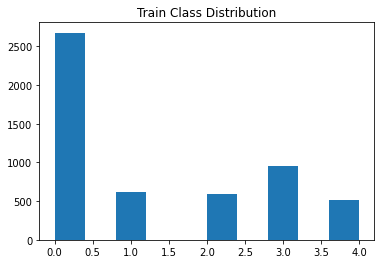

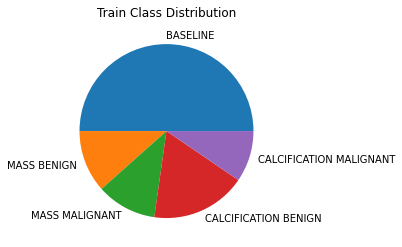

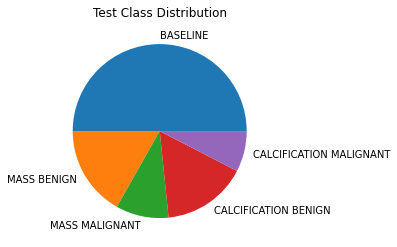

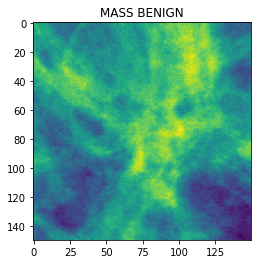

In [6]:
train_images, train_labels= preprocessing.load_images_and_lables(DATA_PATH + 'train_tensor.npy', DATA_PATH + 'train_labels.npy')
test_images, test_labels= preprocessing.load_images_and_lables(DATA_PATH + 'public_test_tensor.npy', DATA_PATH + 'public_test_labels.npy')

# Class Distribution
plt.hist(train_labels)
plt.title("Train Class Distribution")
plt.show()

unique, counts = np.unique(train_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE","MASS BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(test_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE","MASS BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Test Class Distribution')
plt.show()

# Plot an example
img_index = 5
plt.imshow(train_images[img_index,:,:])
plt.title(labels_dict[str(train_labels[img_index])])
plt.show()

## General Data Preprocessing:

Normalize and convert to RGB:

In [7]:
# I also need to convert back to numpy array using eval()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
with sess.as_default():
  print(train_images.shape)
  pp_train_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(train_images, train_images.mean(), train_images.std()))).eval()
  print(pp_train_images.shape)

  print(test_images.shape)
  pp_test_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(test_images, train_images.mean(), train_images.std()))).eval()
  print(pp_test_images.shape)

(5352, 150, 150)
(5352, 150, 150, 3)
(672, 150, 150)
(672, 150, 150, 3)


Test Augmentation:

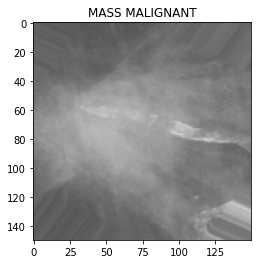

In [8]:
# Test: show random augmented image
for batch in preprocessing.datagen.flow(pp_train_images, train_labels, batch_size=1):
    plt.title(labels_dict[str(batch[1][0])])
    imgplot = plt.imshow(preprocessing.deprocess_image_to_RGB(batch[0][0][:,:,:]))
    break

plt.show()

Binary subdivision:

Masses and Calcifications
(2676, 150, 150, 3)
(2676,)
(336, 150, 150, 3)
(336,)


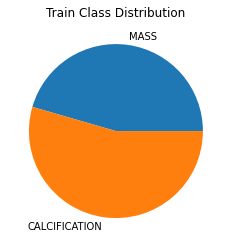

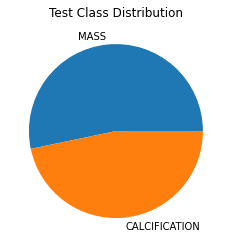

In [9]:
# 0: MASS, 1: CALCIFICATION
mc_train_images, mc_train_labels, mc_test_images, mc_test_labels = preprocessing.binary_subdivision( 
    [1,2], [3,4], pp_train_images, train_labels, pp_test_images, test_labels)  

print("Masses and Calcifications")
print(mc_train_images.shape)
print(mc_train_labels.shape)
print(mc_test_images.shape)
print(mc_test_labels.shape)

# Class Distribution
unique, counts = np.unique(mc_train_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(mc_test_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Test Class Distribution')
plt.show()

# PreTrained Mass VS Calcification Classifiers

### Split:

(2140, 150, 150, 3)
(2140,)
(536, 150, 150, 3)
(536,)


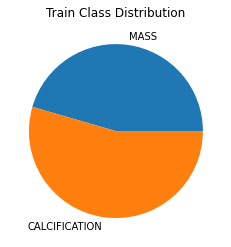

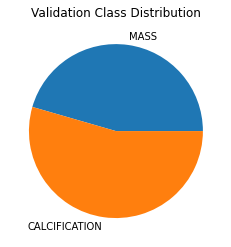

In [10]:
mc_train_images, mc_val_images, mc_train_labels, mc_val_labels = train_test_split(mc_train_images, mc_train_labels, test_size=0.2, random_state=171997, stratify=mc_train_labels)

print(mc_train_images.shape)
print(mc_train_labels.shape)
print(mc_val_images.shape)
print(mc_val_labels.shape)

# Class Distribution
unique, counts = np.unique(mc_train_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(mc_val_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Validation Class Distribution')
plt.show()

###General Parameters for training:

In [11]:
K.clear_session()

In [12]:
# Training parameters that are good for all models

# From ISMMS paper 32
# From Girona & Manchester paper 128
BATCH_SIZE = 107 # to have even batches 
STEPS_PER_EPOCH = len(mc_train_images) // BATCH_SIZE # 20
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00001) # From Ecuador/Brazil paper
LOSS = 'binary_crossentropy'

# Large values ensures to not lose better weights 
MAX_EPOCHS = 1000 
PATIENCE = 50 

# Automatically restore best weights after early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)

##Transfer Learning

### VGG16 Transfer Learning:

In [ ]:
from tensorflow.keras.applications import VGG16

VGG16_TL_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
VGG16_TL_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
from tensorflow.keras.applications import VGG16

VGG16_TL_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
VGG16_TL_base.trainable = False

VGG16_TL_mc = models.Sequential(name = "VGG16_TL_mass_calcification")
VGG16_TL_mc.add(VGG16_TL_base)

VGG16_TL_mc.add(layers.Flatten(name = "flatten"))
VGG16_TL_mc.add(layers.Dropout(0.2))
VGG16_TL_mc.add(layers.Dense(4096, activation='relu', name = "fully_connected_0"))
VGG16_TL_mc.add(layers.Dropout(0.2))
VGG16_TL_mc.add(layers.Dense(4096, activation='relu', name = "fully_connected_1"))
VGG16_TL_mc.add(layers.Dropout(0.1))
VGG16_TL_mc.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

VGG16_TL_mc.summary()

VGG16_TL_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/VGG16_TL_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Model: "VGG16_TL_mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 409

Training:

In [ ]:
VGG16_TL_mc_history = VGG16_TL_mc.fit(preprocessing.datagen.flow(mc_train_images, mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (mc_val_images, mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6603 - accuracy: 0.5949

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 15s 296ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6603 - accuracy: 0.5949 - val_loss: 0.5327 - val_accuracy: 0.7444
Epoch 2/1000
20/20 [==============================] - 10s 523ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5529 - accuracy: 0.7238 - val_loss: 0.4563 - val_accuracy: 0.8134
Epoch 3/1000
20/20 [==============================] - 10s 533ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4865 - accuracy: 0.7991 - val_loss: 0.4106 - val_accuracy: 0.8004
Epoch 4/1000
20/20 [==============================] - 10s 531ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4348 - accuracy: 0.8178 - val_loss: 0.3770 - val_accuracy: 0.8153
Epoch 5/1000
20/20 [==============================] - 10s 529ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4068 - accuracy: 0.8294 - val_loss: 0.3331 - val_accuracy: 0.8246
Epoch 6/1000
20/20 [==============================] - 10s 533ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3758 - accu

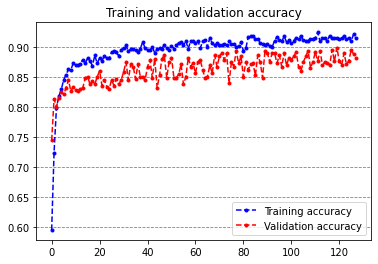

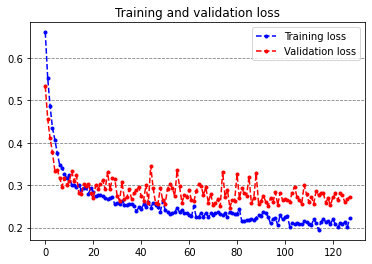

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/VGG16_TL_mc_history', 'wb') as file_pi:
        pickle.dump(VGG16_TL_mc_history.history, file_pi)

VGG16_TL_mc_history = pickle.load(open(HISTORY_PATH + '/VGG16_TL_mc_history', "rb"))

visual.plot_history(VGG16_TL_mc_history)

In [ ]:
train_loss, train_acc = VGG16_TL_mc.evaluate(mc_train_images, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = VGG16_TL_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = VGG16_TL_mc.evaluate(mc_test_images, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 92.71% 
Loss on train set: 0.184
Accuracy on validation set: 89.37% 
Loss on validation set: 0.2943
Accuracy on test set: 88.69% 
Loss on test set: 0.2954


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/VGG16_TL_mc/")
#VGG16_TL_mc.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
VGG16_TL_mc.save(os.path.join(MODELS_PATH,'VGG16_TL_mc.h5'))

### InceptionV3 Transfer Learning:

In [ ]:
from tensorflow.keras.applications import InceptionV3

InceptionV3_TL_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
InceptionV3_TL_base.trainable = False

InceptionV3_TL_mc = models.Sequential(name = "InceptionV3_TL_mass_calcification")
InceptionV3_TL_mc.add(InceptionV3_TL_base)

InceptionV3_TL_mc.add(layers.Flatten(name = "flatten"))
InceptionV3_TL_mc.add(layers.Dropout(0.2))
InceptionV3_TL_mc.add(layers.Dense(2048, activation='relu', name = "fully_connected_0"))
InceptionV3_TL_mc.add(layers.Dropout(0.2))
InceptionV3_TL_mc.add(layers.Dense(2048, activation='relu', name = "fully_connected_1"))
InceptionV3_TL_mc.add(layers.Dropout(0.1))
InceptionV3_TL_mc.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

InceptionV3_TL_mc.summary()

InceptionV3_TL_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/InceptionV3_TL_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

87916544/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3_TL_mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 2048)              37750784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 2048)              4196352   
__________________________________

Training:

In [ ]:
InceptionV3_TL_mc_history = InceptionV3_TL_mc.fit(preprocessing.datagen.flow(mc_train_images, mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (mc_val_images, mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6502 - accuracy: 0.6855

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 13s 444ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6502 - accuracy: 0.6855 - val_loss: 0.5887 - val_accuracy: 0.7705
Epoch 2/1000
20/20 [==============================] - 9s 452ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4856 - accuracy: 0.7836 - val_loss: 0.4541 - val_accuracy: 0.7910
Epoch 3/1000
20/20 [==============================] - 10s 520ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4265 - accuracy: 0.8037 - val_loss: 0.5794 - val_accuracy: 0.8134
Epoch 4/1000
20/20 [==============================] - 10s 512ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4085 - accuracy: 0.8318 - val_loss: 0.5511 - val_accuracy: 0.8209
Epoch 5/1000
20/20 [==============================] - 10s 513ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3907 - accuracy: 0.8318 - val_loss: 0.4729 - val_accuracy: 0.8302
Epoch 6/1000
20/20 [==============================] - 10s 527ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4073 - accur

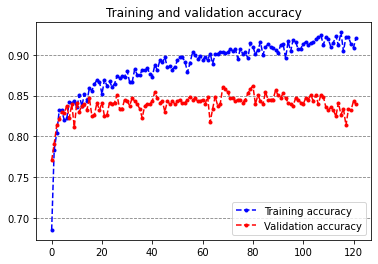

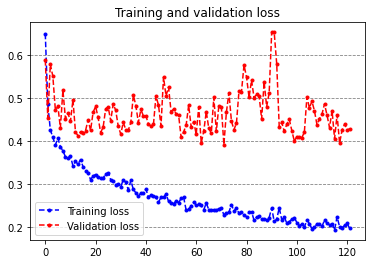

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/InceptionV3_TL_mc_history', 'wb') as file_pi:
        pickle.dump(InceptionV3_TL_mc_history.history, file_pi)

InceptionV3_TL_mc_history = pickle.load(open(HISTORY_PATH + '/InceptionV3_TL_mc_history', "rb"))

visual.plot_history(InceptionV3_TL_mc_history)

In [ ]:
train_loss, train_acc = InceptionV3_TL_mc.evaluate(mc_train_images, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = InceptionV3_TL_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = InceptionV3_TL_mc.evaluate(mc_test_images, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 93.27% 
Loss on train set: 0.1836
Accuracy on validation set: 84.7% 
Loss on validation set: 0.3719
Accuracy on test set: 81.55% 
Loss on test set: 0.4152


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/InceptionV3_TL_mc/")
#InceptionV3_TL_mc.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
InceptionV3_TL_mc.save(os.path.join(MODELS_PATH,'InceptionV3_TL_mc.h5'))

### ResNet50 Transfer Learning:

In [ ]:
from tensorflow.keras.applications import ResNet50

ResNet50_TL_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
ResNet50_TL_base.trainable = False

ResNet50_TL_mc = models.Sequential(name = "ResNet50_TL_mass_calcification")
ResNet50_TL_mc.add(ResNet50_TL_base)

ResNet50_TL_mc.add(layers.Flatten(name = "flatten"))
ResNet50_TL_mc.add(layers.Dropout(0.2))
ResNet50_TL_mc.add(layers.Dense(512, activation='relu', name = "fully_connected_0"))
ResNet50_TL_mc.add(layers.Dropout(0.2))
ResNet50_TL_mc.add(layers.Dense(512, activation='relu', name = "fully_connected_1"))
ResNet50_TL_mc.add(layers.Dropout(0.1))
ResNet50_TL_mc.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

ResNet50_TL_mc.summary()

ResNet50_TL_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/ResNet50_TL_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

94773248/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_TL_mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 51200)             0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 512)               26214912  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 512)               262656    
_____________________________________

Training:

In [ ]:
ResNet50_TL_mc_history = ResNet50_TL_mc.fit(preprocessing.datagen.flow(mc_train_images, mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (mc_val_images, mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6872 - accuracy: 0.5542

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 16s 471ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6872 - accuracy: 0.5542 - val_loss: 0.5430 - val_accuracy: 0.6007
Epoch 2/1000
20/20 [==============================] - 9s 492ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6353 - accuracy: 0.6229 - val_loss: 0.4998 - val_accuracy: 0.6716
Epoch 3/1000
20/20 [==============================] - 10s 527ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6106 - accuracy: 0.6472 - val_loss: 0.4830 - val_accuracy: 0.7146
Epoch 4/1000
20/20 [==============================] - 10s 522ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6085 - accuracy: 0.6561 - val_loss: 0.4887 - val_accuracy: 0.6922
Epoch 5/1000
20/20 [==============================] - 10s 522ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5895 - accuracy: 0.6636 - val_loss: 0.4631 - val_accuracy: 0.7463
Epoch 6/1000
20/20 [==============================] - 10s 527ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5845 - accur

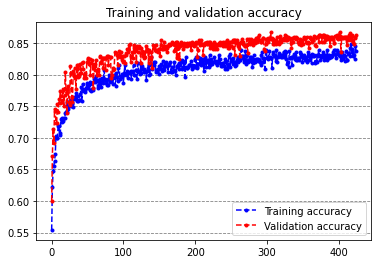

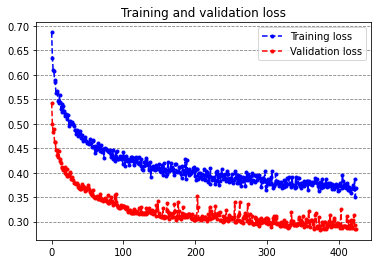

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/ResNet50_TL_mc_history', 'wb') as file_pi:
        pickle.dump(ResNet50_TL_mc_history.history, file_pi)

ResNet50_TL_mc_history = pickle.load(open(HISTORY_PATH + '/ResNet50_TL_mc_history', "rb"))

visual.plot_history(ResNet50_TL_mc_history)

In [ ]:
train_loss, train_acc = ResNet50_TL_mc.evaluate(mc_train_images, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = ResNet50_TL_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = ResNet50_TL_mc.evaluate(mc_test_images, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 87.34% 
Loss on train set: 0.2966
Accuracy on validation set: 86.38% 
Loss on validation set: 0.3388
Accuracy on test set: 83.33% 
Loss on test set: 0.3704


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/ResNet50_TL_mc/")
#ResNet50_TL_mc.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
ResNet50_TL_mc.save(os.path.join(MODELS_PATH,'ResNet50_TL_mc.h5'))

##Fine Tuning

### VGG16 Fine-Tuning:

In [13]:
from tensorflow.keras.applications import VGG16

TOP_K_FROZEN_LAYERS = 8

VGG16_FT_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

VGG16_FT_mc = models.Sequential(name = "VGG16_FT_mass_calcification")
VGG16_FT_mc.add(VGG16_FT_base)

print("Frozen layers:")
for idx in range(TOP_K_FROZEN_LAYERS):
  print(VGG16_FT_base.layers[idx].name)
  VGG16_FT_base.layers[idx].trainable = False

VGG16_FT_mc.add(layers.Flatten(name = "flatten"))
VGG16_FT_mc.add(layers.Dropout(0.2))
VGG16_FT_mc.add(layers.Dense(4096, activation='relu', name = "fully_connected_0"))
VGG16_FT_mc.add(layers.Dropout(0.2))
VGG16_FT_mc.add(layers.Dense(4096, activation='relu', name = "fully_connected_1"))
VGG16_FT_mc.add(layers.Dropout(0.1))
VGG16_FT_mc.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

VGG16_FT_mc.summary()

VGG16_FT_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/VGG16_FT_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Frozen layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
Model: "VGG16_FT_mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 4096)              1678

Training:

In [14]:
VGG16_FT_mc_history = VGG16_FT_mc.fit(preprocessing.datagen.flow(mc_train_images, mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (mc_val_images, mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.5506 - accuracy: 0.7192

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 23s 493ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5506 - accuracy: 0.7192 - val_loss: 0.4088 - val_accuracy: 0.8041
Epoch 2/1000
20/20 [==============================] - 12s 636ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3101 - accuracy: 0.8650 - val_loss: 0.2563 - val_accuracy: 0.8769
Epoch 3/1000
20/20 [==============================] - 13s 653ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2482 - accuracy: 0.9009 - val_loss: 0.2248 - val_accuracy: 0.9011
Epoch 4/1000
20/20 [==============================] - 13s 643ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2338 - accuracy: 0.9047 - val_loss: 0.2048 - val_accuracy: 0.9030
Epoch 5/1000
20/20 [==============================] - 13s 642ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2171 - accuracy: 0.9131 - val_loss: 0.2045 - val_accuracy: 0.9067
Epoch 6/1000
20/20 [==============================] - 13s 640ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2101 - accu

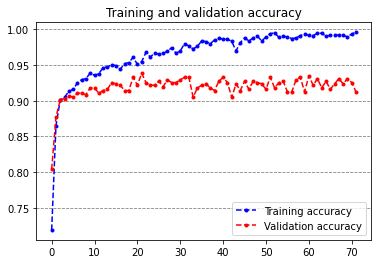

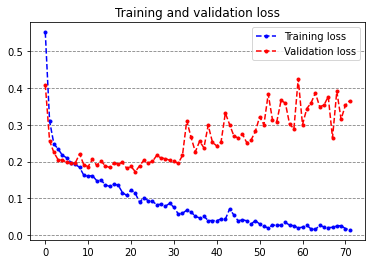

In [15]:
# Save and load history
with open(HISTORY_PATH + '/VGG16_FT_mc_history', 'wb') as file_pi:
        pickle.dump(VGG16_FT_mc_history.history, file_pi)

VGG16_FT_mc_history = pickle.load(open(HISTORY_PATH + '/VGG16_FT_mc_history', "rb"))

visual.plot_history(VGG16_FT_mc_history)

In [16]:
train_loss, train_acc = VGG16_FT_mc.evaluate(mc_train_images, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = VGG16_FT_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = VGG16_FT_mc.evaluate(mc_test_images, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 97.85% 
Loss on train set: 0.0641
Accuracy on validation set: 93.84% 
Loss on validation set: 0.2066
Accuracy on test set: 89.88% 
Loss on test set: 0.2793


Load best weights and save:

In [17]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/VGG16_FT_mc/")
#VGG16_FT_mc.load_weights(best)

In [18]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
VGG16_FT_mc.save(os.path.join(MODELS_PATH,'VGG16_FT_mc.h5'))

### InceptionV3 Fine-Tuning:

In [19]:
from tensorflow.keras.applications import InceptionV3

InceptionV3_FT_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

InceptionV3_FT_mc = models.Sequential(name = "InceptionV3_FT_mass_calcification")
InceptionV3_FT_mc.add(InceptionV3_FT_base)

InceptionV3_FT_mc.add(layers.Flatten(name = "flatten"))
InceptionV3_FT_mc.add(layers.Dropout(0.2))
InceptionV3_FT_mc.add(layers.Dense(2048, activation='relu', name = "fully_connected_0"))
InceptionV3_FT_mc.add(layers.Dropout(0.2))
InceptionV3_FT_mc.add(layers.Dense(2048, activation='relu', name = "fully_connected_1"))
InceptionV3_FT_mc.add(layers.Dropout(0.1))
InceptionV3_FT_mc.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

InceptionV3_FT_mc.summary()

InceptionV3_FT_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/InceptionV3_FT_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

87916544/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3_FT_mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 2048)              37750784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 2048)              4196352   
__________________________________

Training:

In [20]:
InceptionV3_FT_mc_history = InceptionV3_FT_mc.fit(preprocessing.datagen.flow(mc_train_images, mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (mc_val_images, mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6033 - accuracy: 0.6808

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 42s 774ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6033 - accuracy: 0.6808 - val_loss: 0.5897 - val_accuracy: 0.5951
Epoch 2/1000
20/20 [==============================] - 9s 458ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4267 - accuracy: 0.8028 - val_loss: 0.4805 - val_accuracy: 0.7239
Epoch 3/1000
20/20 [==============================] - 13s 654ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3284 - accuracy: 0.8556 - val_loss: 0.4410 - val_accuracy: 0.7743
Epoch 4/1000
20/20 [==============================] - 13s 652ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2765 - accuracy: 0.8841 - val_loss: 0.4119 - val_accuracy: 0.8358
Epoch 5/1000
20/20 [==============================] - 13s 657ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2550 - accuracy: 0.8958 - val_loss: 0.4263 - val_accuracy: 0.8097
Epoch 6/1000
20/20 [==============================] - 13s 651ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.2542 - accur

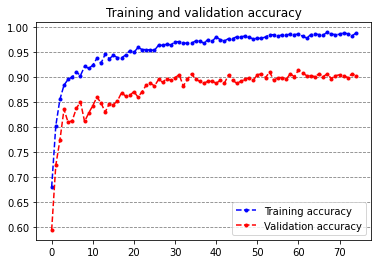

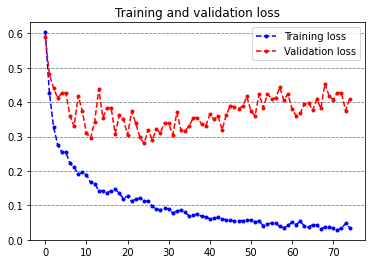

In [21]:
# Save and load history
with open(HISTORY_PATH + '/InceptionV3_FT_mc_history', 'wb') as file_pi:
        pickle.dump(InceptionV3_FT_mc_history.history, file_pi)

InceptionV3_FT_mc_history = pickle.load(open(HISTORY_PATH + '/InceptionV3_FT_mc_history', "rb"))

visual.plot_history(InceptionV3_FT_mc_history)

In [22]:
train_loss, train_acc = InceptionV3_FT_mc.evaluate(mc_train_images, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = InceptionV3_FT_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = InceptionV3_FT_mc.evaluate(mc_test_images, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 95.47% 
Loss on train set: 0.117
Accuracy on validation set: 88.81% 
Loss on validation set: 0.3355
Accuracy on test set: 89.29% 
Loss on test set: 0.2834


Load best weights and save:

In [23]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/InceptionV3_FT_mc/")
#InceptionV3_FT_mc.load_weights(best)

In [24]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
InceptionV3_FT_mc.save(os.path.join(MODELS_PATH,'InceptionV3_FT_mc.h5'))

### ResNet50 Fine-Tuning:

In [28]:
from tensorflow.keras.applications import ResNet50

TOP_K_FROZEN_LAYERS = 170

ResNet50_FT_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

ResNet50_FT_mc = models.Sequential(name = "ResNet50_FT_mass_calcification")
ResNet50_FT_mc.add(ResNet50_FT_base)

print("Frozen layers:")
for idx in range(TOP_K_FROZEN_LAYERS):
  print(ResNet50_FT_base.layers[idx].name)
  ResNet50_FT_base.layers[idx].trainable = False

ResNet50_FT_mc.add(layers.Flatten(name = "flatten"))
ResNet50_FT_mc.add(layers.Dropout(0.2))
ResNet50_FT_mc.add(layers.Dense(512, activation='relu', name = "fully_connected_0"))
ResNet50_FT_mc.add(layers.Dropout(0.2))
ResNet50_FT_mc.add(layers.Dense(512, activation='relu', name = "fully_connected_1"))
ResNet50_FT_mc.add(layers.Dropout(0.1))
ResNet50_FT_mc.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

ResNet50_FT_mc.summary()

ResNet50_FT_mc.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/ResNet50_FT_mc/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Frozen layers:
input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_blo

Training:

In [ ]:
ResNet50_FT_mc_history = ResNet50_FT_mc.fit(preprocessing.datagen.flow(mc_train_images, mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (mc_val_images, mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.5963 - accuracy: 0.7238

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 26s 740ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5963 - accuracy: 0.7238 - val_loss: 0.6875 - val_accuracy: 0.5448
Epoch 2/1000
20/20 [==============================] - 6s 300ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3976 - accuracy: 0.8341 - val_loss: 0.7020 - val_accuracy: 0.4963
Epoch 3/1000
20/20 [==============================] - 10s 522ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3541 - accuracy: 0.8449 - val_loss: 0.7205 - val_accuracy: 0.4683
Epoch 4/1000
20/20 [==============================] - 10s 529ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3540 - accuracy: 0.8547 - val_loss: 0.7631 - val_accuracy: 0.4571
Epoch 5/1000
20/20 [==============================] - 10s 526ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3231 - accuracy: 0.8598 - val_loss: 0.7675 - val_accuracy: 0.4571
Epoch 6/1000
20/20 [==============================] - 10s 522ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3249 - accur

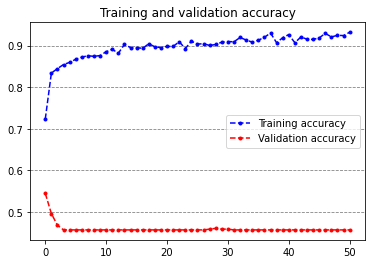

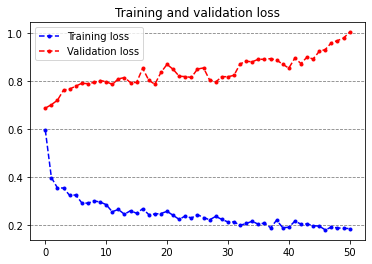

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/ResNet50_FT_mc_history', 'wb') as file_pi:
        pickle.dump(ResNet50_FT_mc_history.history, file_pi)

ResNet50_FT_mc_history = pickle.load(open(HISTORY_PATH + '/ResNet50_FT_mc_history', "rb"))

visual.plot_history(ResNet50_FT_mc_history)

In [ ]:
train_loss, train_acc = ResNet50_FT_mc.evaluate(mc_train_images, mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = ResNet50_FT_mc.evaluate(mc_val_images, mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = ResNet50_FT_mc.evaluate(mc_test_images, mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 54.21% 
Loss on train set: 0.6908
Accuracy on validation set: 54.48% 
Loss on validation set: 0.692
Accuracy on test set: 45.83% 
Loss on test set: 0.7145


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/ResNet50_FT_mc/")
#ResNet50_FT_mc.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
ResNet50_FT_mc.save(os.path.join(MODELS_PATH,'ResNet50_FT_mc.h5'))

## Load Results

In [25]:
VGG16_TL_mc = keras.models.load_model(os.path.join(MODELS_PATH,'VGG16_TL_mc.h5'))

In [26]:
InceptionV3_TL_mc = keras.models.load_model(os.path.join(MODELS_PATH,'InceptionV3_TL_mc.h5'))

In [27]:
ResNet50_TL_mc = keras.models.load_model(os.path.join(MODELS_PATH,'ResNet50_TL_mc.h5'))

In [16]:
VGG16_FT_mc = keras.models.load_model(os.path.join(MODELS_PATH,'VGG16_FT_mc.h5'))

In [17]:
InceptionV3_FT_mc = keras.models.load_model(os.path.join(MODELS_PATH,'InceptionV3_FT_mc.h5'))

In [ ]:
ResNet50_FT_mc = keras.models.load_model(os.path.join(MODELS_PATH,'ResNet50_FT_mc.h5'))

## Support Vectors Machines 

Extract Features:

In [ ]:
FT_LAYER = -7 # FE starts from -7th layer

VGG16_TL_mc_fe = svm.create_feature_extractor(VGG16_TL_mc, FT_LAYER, layers.Flatten(name = "flatten"))
VGG16_TL_mc_fe.summary()

InceptionV3_TL_mc_fe = svm.create_feature_extractor(InceptionV3_TL_mc, FT_LAYER, layers.Flatten(name = "flatten"))
InceptionV3_TL_mc_fe.summary()

ResNet50_TL_mc_fe = svm.create_feature_extractor(ResNet50_TL_mc, FT_LAYER), layers.Flatten(name = "flatten")
ResNet50_TL_mc_fe.summary()

VGG16_FT_mc_fe = svm.create_feature_extractor(VGG16_FT_mc, FT_LAYER, layers.Flatten(name = "flatten"))
VGG16_FT_mc_fe.summary()

InceptionV3_FT_mc_fe = svm.create_feature_extractor(InceptionV3_FT_mc, FT_LAYER, layers.Flatten(name = "flatten"))
InceptionV3_FT_mc_fe.summary()


In [ ]:
m1_train_features, m1_val_features, m1_test_features = svm.extract_features(VGG16_TL_mc_fe, mc_train_images, mc_val_images, mc_test_images)
m2_train_features, m2_val_features, m2_test_features = svm.extract_features(InceptionV3_TL_mc_fe, mc_train_images, mc_val_images, mc_test_images)
m3_train_features, m3_val_features, m3_test_features = svm.extract_features(ResNet50_TL_mc_fe, mc_train_images, mc_val_images, mc_test_images)

m4_train_features, m4_val_features, m4_test_features = svm.extract_features(VGG16_FT_mc_fe, mc_train_images, mc_val_images, mc_test_images)
m5_train_features, m5_val_features, m5_test_features = svm.extract_features(InceptionV3_FT_mc_fe, mc_train_images, mc_val_images, mc_test_images)

Train SVM on extracted features:

In [ ]:
VGG16_TL_mc_SVM = svm.train_svm_classifier(m1_train_features, mc_train_labels, m1_val_features, mc_val_labels, ker = "linear", gam='scale', c = 8)

In [ ]:
InceptionV3_TL_mc_SVM = svm.train_svm_classifier(m2_train_features, mc_train_labels, m2_val_features, mc_val_labels, ker = "rbf", gam='scale', c = 10)

In [ ]:
ResNet50_TL_mc_SVM = svm.train_svm_classifier(m3_train_features, mc_train_labels, m3_val_features, mc_val_labels, ker = "linear", gam='scale', c = 10)

In [ ]:
VGG16_FT_mc_SVM = svm.train_svm_classifier(m4_train_features, mc_train_labels, m4_val_features, mc_val_labels, ker = "linear", gam='scale', c = 8)

In [ ]:
InceptionV3_FT_mc_SVM = svm.train_svm_classifier(m5_train_features, mc_train_labels, m5_val_features, mc_val_labels, ker = "rbf", gam='scale', c = 10)

# Compare Results

##Scoring:

VGG16 -----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


VGG16_TL
Accuracy on test set: 88.69% 
Loss on test set: 0.2954


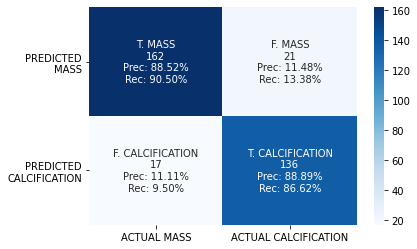

VGG16_FT
Accuracy on test set: 89.88% 
Loss on test set: 0.2793


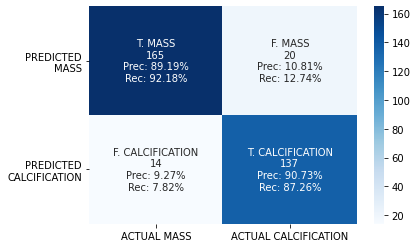

InceptionV3 -----------------------------------------------------------------
InceptionV3_TL
Accuracy on test set: 81.55% 
Loss on test set: 0.4152


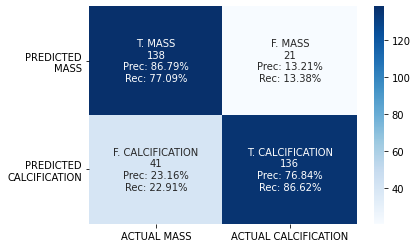

InceptionV3_FT
Accuracy on test set: 89.29% 
Loss on test set: 0.2834


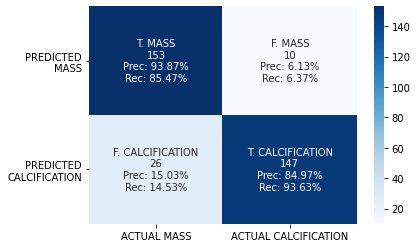

ResNet50 -----------------------------------------------------------------
ResNet50_TL
Accuracy on test set: 83.33% 
Loss on test set: 0.3704


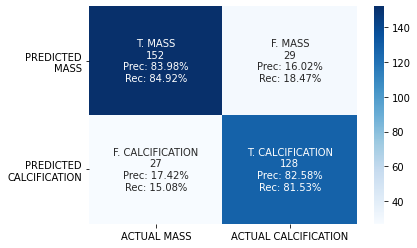

ResNet50_FT
Accuracy on test set: 42.86% 
Loss on test set: 0.6931


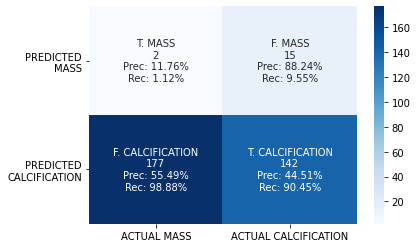

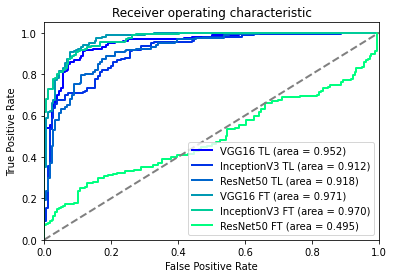

In [29]:
# VGG16 -----------------------------------------
print("VGG16 -----------------------------------------------------------------")

# Transfer Learning
test_loss, test_acc = VGG16_TL_mc.evaluate(mc_test_images, mc_test_labels)
print("VGG16_TL")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

VGG16_TL_mc_test_predictions = VGG16_TL_mc.predict(mc_test_images)
binary_VGG16_TL_mc_test_predictions = VGG16_TL_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_VGG16_TL_mc_test_predictions, ["MASS", "CALCIFICATION"])
'''
test_acc = VGG16_TL_mc_SVM.score(m1_test_features, mc_test_labels)
print("VGG16_TL_SVG")
print(f"Accuracy on test set: {round(test_acc*100, 2)}%")

VGG16_TL_mc_SVM_test_predictions = VGG16_TL_mc_SVM.predict_proba(m1_test_features)
binary_VGG16_TL_mc_SVM_test_predictions = VGG16_TL_mc_SVM_test_predictions[:,1].round()
visual.plot_confusion_matrix(mc_test_labels, binary_VGG16_TL_mc_SVM_test_predictions, ["MASS", "CALCIFICATION"])
'''
# Fine Tuning
test_loss, test_acc = VGG16_FT_mc.evaluate(mc_test_images, mc_test_labels)
print("VGG16_FT")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

VGG16_FT_mc_test_predictions = VGG16_FT_mc.predict(mc_test_images)
binary_VGG16_FT_mc_test_predictions = VGG16_FT_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_VGG16_FT_mc_test_predictions, ["MASS", "CALCIFICATION"])

# InceptionV3 -----------------------------------------
print("InceptionV3 -----------------------------------------------------------------")

# Transfer Learning
test_loss, test_acc = InceptionV3_TL_mc.evaluate(mc_test_images, mc_test_labels)
print("InceptionV3_TL")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

InceptionV3_TL_mc_test_predictions = InceptionV3_TL_mc.predict(mc_test_images)
binary_InceptionV3_TL_mc_test_predictions = InceptionV3_TL_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_InceptionV3_TL_mc_test_predictions, ["MASS", "CALCIFICATION"])

# Fine Tuning
test_loss, test_acc = InceptionV3_FT_mc.evaluate(mc_test_images, mc_test_labels)
print("InceptionV3_FT")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

InceptionV3_FT_mc_test_predictions = InceptionV3_FT_mc.predict(mc_test_images)
binary_InceptionV3_FT_mc_test_predictions = InceptionV3_FT_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_InceptionV3_FT_mc_test_predictions, ["MASS", "CALCIFICATION"])

# ResNet50 -----------------------------------------
print("ResNet50 -----------------------------------------------------------------")

# Transfer Learning
test_loss, test_acc = ResNet50_TL_mc.evaluate(mc_test_images, mc_test_labels)
print("ResNet50_TL")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

ResNet50_TL_mc_test_predictions = ResNet50_TL_mc.predict(mc_test_images)
binary_ResNet50_TL_mc_test_predictions = ResNet50_TL_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_ResNet50_TL_mc_test_predictions, ["MASS", "CALCIFICATION"])

# Fine Tuning
test_loss, test_acc = ResNet50_FT_mc.evaluate(mc_test_images, mc_test_labels)
print("ResNet50_FT")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

ResNet50_FT_mc_test_predictions = ResNet50_FT_mc.predict(mc_test_images)
binary_ResNet50_FT_mc_test_predictions = ResNet50_FT_mc_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_ResNet50_FT_mc_test_predictions, ["MASS", "CALCIFICATION"])


# ROC -------------------------------------------------------------------------------------
models_predictions = [VGG16_TL_mc_test_predictions,
                      InceptionV3_TL_mc_test_predictions,
                      ResNet50_TL_mc_test_predictions,
                      VGG16_FT_mc_test_predictions,
                      InceptionV3_FT_mc_test_predictions,
                      ResNet50_FT_mc_test_predictions]


visual.plot_roc_curve(mc_test_labels, models_predictions, ["VGG16 TL","InceptionV3 TL","ResNet50 TL", "VGG16 FT","InceptionV3 FT","ResNet50 FT"])

##Visual Results:

In [ ]:
# Filters patterns
visual.display_filters_patterns_RGB(top_k = len(VGG16_TL_base.layers), model = VGG16_TL_base, size = 150, images_per_row = 16, scale = 1, grad_steps = 40)

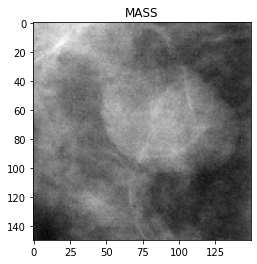

In [ ]:
#Example Image
img_index = 33
IMG = mc_test_images[img_index:img_index + 1] # visualized image

plt.imshow(preprocessing.deprocess_image(IMG[0,:,:,0]),cmap = 'gray')
if mc_test_labels[img_index] == 0:
  plt.title("MASS")
else:
  plt.title("CALCIFICATION")
plt.show()

In [ ]:
# Feature Maps
visual.display_features_maps(bottom_layer = 1, top_k = len(VGG16_TL_base.layers) - 1, model = VGG16_TL_base, example_image = IMG, images_per_row = 16, scale = 1)

Author: **Stefano Petrocchi**
